In [107]:
previous_losses = []

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | fc1     | Linear  | 128    | train
1 | tanh    | Tanh    | 0      | train
2 | fc2     | Linear  | 65     | train
3 | loss_fn | MSELoss | 0      | train
--------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/Users/r/.venvs/p3inn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/r/.venvs/p3inn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: Th

Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 147.60it/s, v_num=48]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 100.60it/s, v_num=48]
0.0027109449729323387 0.0023823704104870558


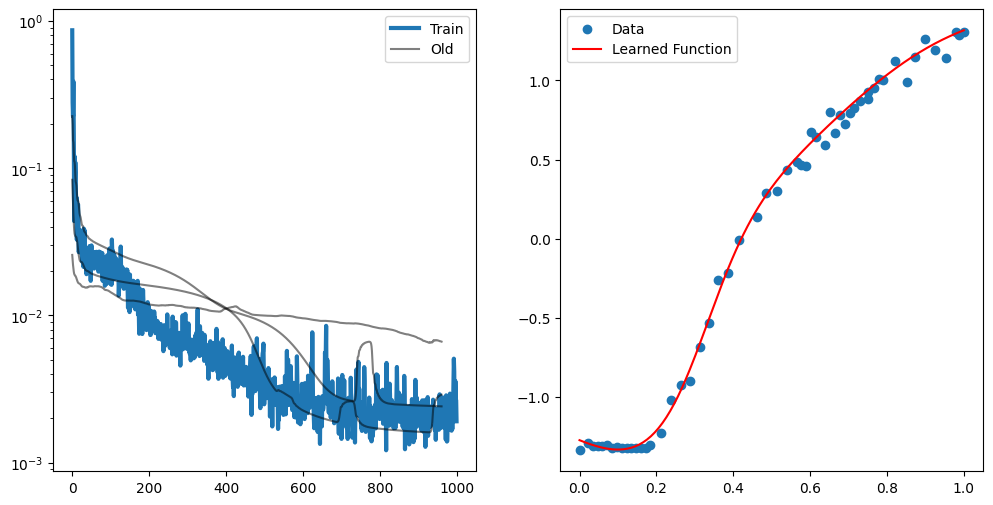

In [112]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Data preprocessing function
def preprocess_data(x_path, y_path):
    x = np.load(x_path)
    y = np.load(y_path)

    # Reshape to 2D for scaler (required by sklearn)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_scaler = MinMaxScaler()
    y_scaler = StandardScaler()
    x_scaled = x_scaler.fit_transform(x)
    y_scaled = y_scaler.fit_transform(y)

    # Back to 1D (for our model) after scaling:
    x_scaled = x_scaled.reshape(-1)
    y_scaled = y_scaled.reshape(-1)

    return x_scaled, y_scaled


x_scaled, y_scaled = preprocess_data(
    "../data_out/p3inn/core2/x_data.npy", "../data_out/p3inn/core2/y_data.npy"
)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_scaled, dtype=torch.float32).unsqueeze(
    -1
)  # Add dimension for single input feature
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(
    -1
)  # Add dimension for single output


# Define the MLP model
class MLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.MSELoss()
        self.training_losses = []

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        if batch_idx == 0:
            self.training_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.06)
        return optimizer


# Initialize the model and trainer
mlp = MLP(input_size=1, hidden_size=64, output_size=1)
trainer = pl.Trainer(max_epochs=1000, enable_progress_bar=True)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

training_duration_s = time.time()
trainer.fit(mlp, dataloader)
training_duration_s = time.time() - training_duration_s



# ========================================================================
# Plot the results
# ========================================================================
with torch.no_grad():
    x_plot = torch.linspace(x_scaled.min(), x_scaled.max(), 200).unsqueeze(
        -1
    )  # Scaled input for prediction
    y_pred = mlp(x_plot)

    final_mse_loss = nn.MSELoss()(mlp(x_tensor), y_tensor).item()
    print(final_mse_loss, mlp.training_losses[-1])


def moving_average(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode="valid")

def scale_loss(losses, target):
    losses = np.array(losses)
    last_loss = losses[-20:].mean()
    # scale such that last loss is 1
    losses /= last_loss
    # scale such that last loss is target
    losses *= target
    return losses

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

axs[0].semilogy(scale_loss(mlp.training_losses, final_mse_loss), label="Train", lw=3)
for i, (old_final_mse, old_loss) in enumerate(previous_losses):
    old_loss = scale_loss(old_loss, old_final_mse)
    old_loss = moving_average(old_loss, window_size=40)
    color = "k"
    axs[0].semilogy(old_loss, "-", color=color, alpha=0.5, label="Old" if i == 0 else ""
    )
axs[0].legend()
# axs[0].set_xlim(0, 3e10)
# axs[0].set_ylim(2*1e-3, 1e-1)
previous_losses.append((final_mse_loss, mlp.training_losses))

axs[1].scatter(x_scaled, y_scaled, label="Data")
axs[1].plot(x_plot.numpy(), y_pred.numpy(), color="red", label="Learned Function")
axs[1].legend()

plt.show()
!say "Done"

In [129]:
residuals = (y_tensor - model(x_tensor))[:, 0].numpy()
residuals -= np.median(residuals)

print(np.count_nonzero(residuals >= 0), np.count_nonzero(residuals < 0))

np.save("/tmp/res_up.npy", [x_scaled[residuals >= 0], residuals[residuals >= 0]])
np.save("/tmp/res_down.npy", [x_scaled[residuals < 0], residuals[residuals < 0]])

28 27


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | fc1     | Linear  | 128    | train
1 | tanh    | Tanh    | 0      | train
2 | fc2     | Linear  | 65     | train
3 | loss_fn | MSELoss | 0      | train
--------------------------------------------
193       Trainable params
0         Non-trainable params
193       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/Users/r/.venvs/p3inn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/r/.venvs/p3inn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: Th

Epoch 499: 100%|██████████| 2/2 [00:00<00:00, 135.47it/s, v_num=50]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 2/2 [00:00<00:00, 83.39it/s, v_num=50] 
0.4968556761741638 0.5293081998825073


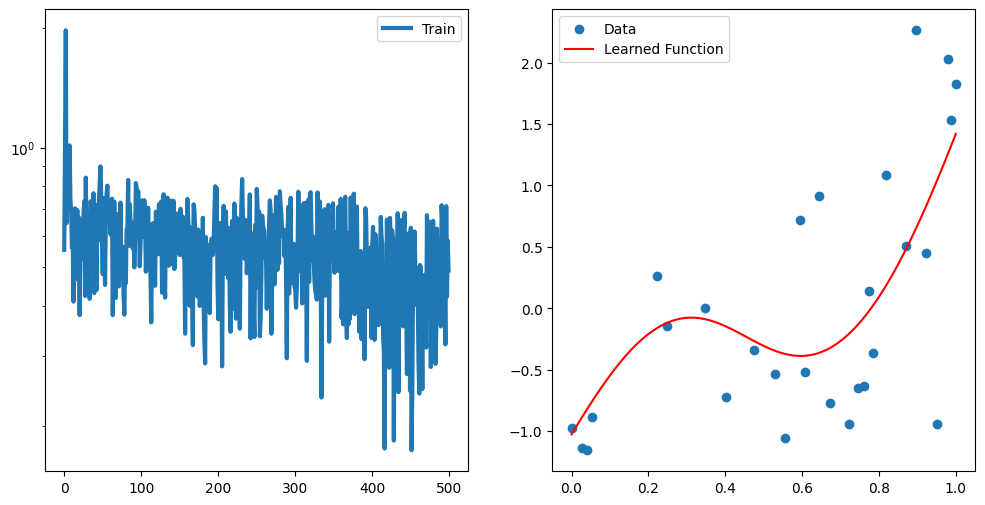

In [131]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Data preprocessing function
def preprocess_data(path):
    x, y = np.load(path)

    # Reshape to 2D for scaler (required by sklearn)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_scaler = MinMaxScaler()
    y_scaler = StandardScaler()
    x_scaled = x_scaler.fit_transform(x)
    y_scaled = y_scaler.fit_transform(y)

    # Back to 1D (for our model) after scaling:
    x_scaled = x_scaled.reshape(-1)
    y_scaled = y_scaled.reshape(-1)

    return x_scaled, y_scaled


x_scaled, y_scaled = preprocess_data("/tmp/res_up.npy")

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_scaled, dtype=torch.float32).unsqueeze(
    -1
)  # Add dimension for single input feature
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(
    -1
)  # Add dimension for single output


# Define the MLP model
class MLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.MSELoss()
        self.training_losses = []

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        if batch_idx == 0:
            self.training_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.06)
        return optimizer


# Initialize the model and trainer
mlp = MLP(input_size=1, hidden_size=64, output_size=1)
trainer = pl.Trainer(max_epochs=500, enable_progress_bar=True)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

training_duration_s = time.time()
trainer.fit(mlp, dataloader)
training_duration_s = time.time() - training_duration_s



# ========================================================================
# Plot the results
# ========================================================================
with torch.no_grad():
    x_plot = torch.linspace(x_tensor.min(), x_tensor.max(), 200).unsqueeze(
        -1
    )  # Scaled input for prediction
    y_pred = mlp(x_plot)

    final_mse_loss = nn.MSELoss()(mlp(x_tensor), y_tensor).item()
    print(final_mse_loss, mlp.training_losses[-1])


def moving_average(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode="valid")

def scale_loss(losses, target):
    losses = np.array(losses)
    last_loss = losses[-20:].mean()
    # scale such that last loss is 1
    losses /= last_loss
    # scale such that last loss is target
    losses *= target
    return losses

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

axs[0].semilogy(scale_loss(mlp.training_losses, final_mse_loss), label="Train", lw=3)
axs[0].legend()
# axs[0].set_xlim(0, 3e10)
# axs[0].set_ylim(2*1e-3, 1e-1)

axs[1].scatter(x_tensor, y_tensor, label="Data")
axs[1].plot(x_plot.numpy(), y_pred.numpy(), color="red", label="Learned Function")
axs[1].legend()

plt.show()
!say "Done"

--------------

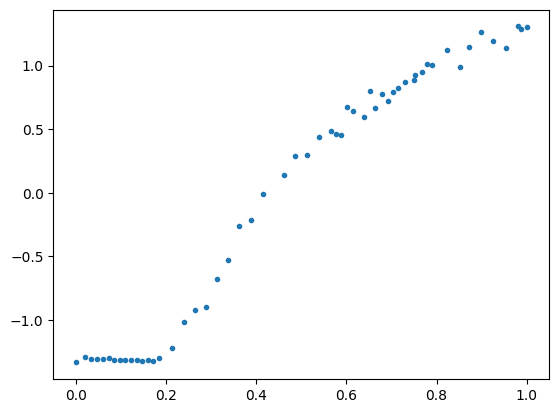

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6979 - val_loss: 0.1074
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1343 - val_loss: 0.4999
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1326 - val_loss: 0.1836
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0698 - val_loss: 0.1616
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1371 - val_loss: 0.0185
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0531 - val_loss: 0.2160
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0624 - val_loss: 0.5966
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0627 - val_loss: 0.1634
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0320 - val_loss: 0.0939
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0447 - val_loss: 0.0335
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366 - val_loss: 0.2002
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 - 

KeyboardInterrupt: 

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# def preprocess_data(x_path, y_path):
#     x = np.load(x_path)
#     y = np.load(y_path)

#     # Reshape to 2D for scaler (required by sklearn)
#     x = x.reshape(-1, 1)
#     y = y.reshape(-1, 1)

#     x_scaler = MinMaxScaler()
#     y_scaler = StandardScaler()
#     x_scaled = x_scaler.fit_transform(x)
#     y_scaled = y_scaler.fit_transform(y)

#     # Back to 1D (for our model) after scaling:
#     x_scaled = x_scaled.reshape(-1)
#     y_scaled = y_scaled.reshape(-1)

#     return x_scaled, y_scaled


# x_scaled, y_scaled = preprocess_data(
#     "../data_out/p3inn/core2/x_data.npy", "../data_out/p3inn/core2/y_data.npy"
# )

# Load data from .npy files
x = np.load("../data_out/p3inn/core2/x_data.npy")
y = np.load("../data_out/p3inn/core2/y_data.npy")

# Reshape x if it's 1D to ensure it's a column vector
if x.ndim == 1:
    x = x.reshape(-1, 1)

x_train = x.copy()
y_train = y.copy()

# Normalize data
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

del scaler_x
del scaler_y

plt.plot(x_train, y_train, ".")
plt.show()
# raise


MAX_EPOCHS = 1000
MIN_MSE_LOSS = 0.0025  # best I got so far was 0.00221
MIN_MAE_LOSS = 0.034  # best I got so far was 0.034
INITIAL_LEARNING_RATE = 0.04
ACTIVATION_FUN = "tanh"
LOSS_FUN = "mse"
if LOSS_FUN == "mse":
    MIN_LOSS = MIN_MSE_LOSS
else:
    MIN_LOSS = MIN_MAE_LOSS

# Keras model
model = keras.models.Sequential(
    [
        keras.Input(shape=(1,)),
        keras.layers.Dense(64, activation=ACTIVATION_FUN),
        keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.06),  # type: ignore
    loss=LOSS_FUN,
)


class LossThresholdCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get("loss") < MIN_LOSS:
            print(f"\nReached MIN_LOSS of {MIN_LOSS}. Stopping training.")
            self.model.stop_training = True  # type: ignore


MIN_DELTA = MIN_LOSS / 5
EARLY_STOP_PATIENCE = MAX_EPOCHS // 10

callbacks = [
    # keras.callbacks.ReduceLROnPlateau(
    #     "loss",
    #     factor=0.5,
    #     patience=EARLY_STOP_PATIENCE // 4,
    #     min_delta=MIN_DELTA,
    #     min_lr=1e-5,
    #     cooldown=EARLY_STOP_PATIENCE // 2,
    #     verbose=1,
    # ),
    keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=EARLY_STOP_PATIENCE,
        min_delta=MIN_DELTA,  # type: ignore
        restore_best_weights=True,
        verbose=1,
    ),
    # keras.callbacks.TerminateOnNaN(),
    # LossThresholdCallback(),
    # keras.callbacks.ModelCheckpoint(
    #     filepath="best_model.keras",
    #     monitor="loss",
    #     save_best_only=True,
    #     save_weights_only=False,
    #     mode="min",
    #     verbose=0,
    # ),
]


# Training
history = model.fit(
    x_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=16,
    #callbacks=callbacks,
    validation_split=0.2,
    verbose=1,  # type: ignore
)


# Plotting the Results
x_plot = np.linspace(x_scaled.min(), x_scaled.max(), 200).reshape(-1, 1)
y_pred = model.predict(x_plot)

print(np.min(history.history["loss"]))

plt.figure(figsize=(10, 5))
plt.scatter(x_scaled, y_scaled, label="Data")
plt.plot(x_plot, y_pred, color="red", label="Learned Function")
plt.title("MLP Regression (Keras)")
plt.xlabel("Scaled x")
plt.ylabel("Scaled y")
plt.legend()


# Plot training loss
plt.figure(figsize=(10, 5))
plt.semilogy(history.history["loss"], label="Training Loss")
plt.title("Training Loss (Keras)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8444 - val_loss: 0.1154
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3801 - val_loss: 0.0829
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0794 - val_loss: 0.7841
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1165 - val_loss: 0.8678
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1200 - val_loss: 0.2984
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0604 - val_loss: 0.1809
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - val_loss: 0.0155
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0717 - val_loss: 0.0270
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0703 - val_loss: 0.0753
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0486 - val_loss: 0.1942
Epoch 11/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - val_loss: 0.1876
Epoch 12/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0399 - val_l

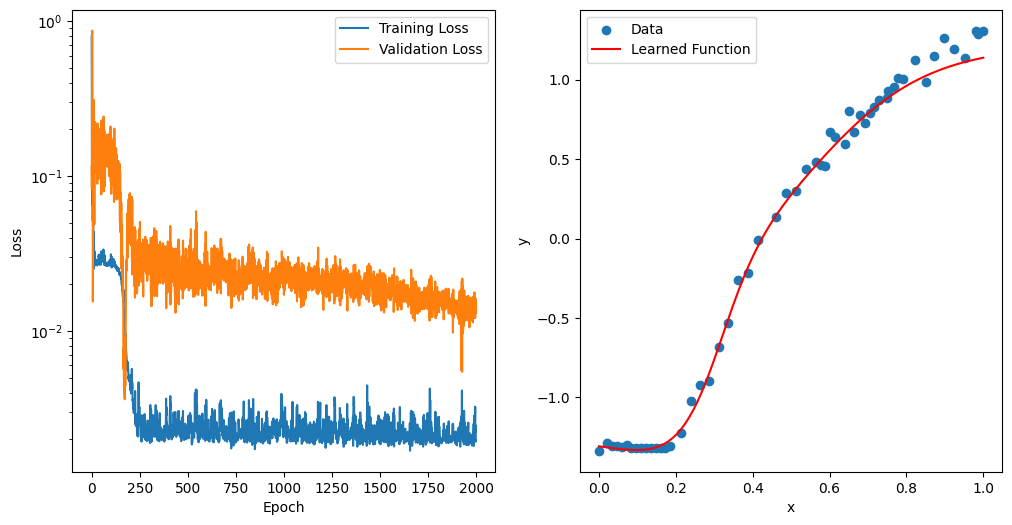

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load data from .npy files
x = np.load("../data_out/p3inn/core2/x_data.npy")
y = np.load("../data_out/p3inn/core2/y_data.npy")

# Reshape x if it's 1D to ensure it's a column vector
if x.ndim == 1:
    x = x.reshape(-1, 1)

x_train = x.copy()
y_train = y.copy()

# Normalize data
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

del scaler_x
del scaler_y


model = keras.Sequential(
    [
        keras.Input(shape=(1,)),
        keras.layers.Dense(192, activation="tanh"),
        keras.layers.Dense(64, activation="tanh"),
        keras.layers.Dense(1),
    ]
)


learning_rate = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.037369,
    decay_rate=0.8,
    decay_steps=60,
)
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss="mse")


EARLY_STOPPING_PARAMS = dict(monitor="loss", patience=150, min_delta=0.0001)
TRAINING_PARAMS = dict(
    batch_size=16,
    epochs=2000,
    validation_split=0.2,
)

# Train the best model
history = model.fit(
    x_train,
    y_train,
    **TRAINING_PARAMS,
    # callbacks=[keras.callbacks.EarlyStopping(**EARLY_STOPPING_PARAMS)],
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.semilogy(history.history["loss"], label="Training Loss")
ax1.semilogy(history.history["val_loss"], label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()


# Plot learned function and data
x_plot = np.linspace(x_train.min(), x_train.max(), 200).reshape(
    -1, 1
)  # 200 points for smooth curve

# x_plot_scaled = scaler_x.transform(x_plot)  # Scale the x values for prediction
# y_pred_scaled = best_model.predict(x_plot_scaled)
# y_pred = scaler_y.inverse_transform(
#     y_pred_scaled
# ).flatten()  # Inverse scale predictions

x_plot_scaled = x_plot
y_pred = model.predict(x_plot_scaled)


ax2.scatter(x_train, y_train, label="Data")
ax2.plot(x_plot, y_pred, color="red", label="Learned Function")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
plt.show()

In [17]:
import math

s_per_epoch = 7 / 200
max_epochs = 500
factor = 3
iterations = 3
n_epochs = int(iterations * max_epochs * (math.log(max_epochs, factor) ** 2))
print(f"{n_epochs=}, dt={s_per_epoch * n_epochs / 60:.1f} min")

n_epochs=63998, dt=37.3 min


In [ ]:
max_epochs * (math.log(max_epochs, factor) ** 2)